Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [12]:
%matplotlib inline

In [13]:
from __future__ import print_function
import sys
sys.path.append("/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/")
import math

In [14]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [15]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from nn import *
import pickle

In [16]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state)


In [17]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

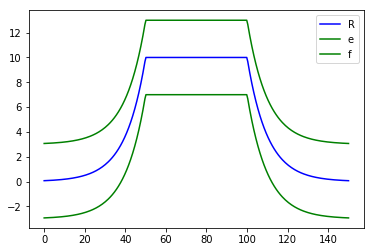

In [18]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))
    else:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))
      
posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [20, 20]
q2 = [0.01, 0.01]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])



Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [25]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0] # Initial state.
# Random initial action path.
us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
#us_init = np.zeros((N, dynamics.action_size))

num_epoch = 5
for i_epoch in range(num_epoch):
    print("Epoch %d" % i_epoch)
    for i in range(0, int(N - n) + 1):
        print("Step %d" % i)
        if i % n != 0:
            #continue
            pass
        x_path_ = x_path[i: i + n]
        cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
        ilqr = iLQR(dynamics, cost, n - 1)
        xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

        x_path_.append(x0)
        expert_traj = expert_traj + [[x_path_, us[0]]]

        #expert_traj = expert_traj + [[xs[i], us[i]] for i in range(len(xs) - 1)]
        seed = np.random.uniform(-3, 3, dynamics.state_size)
        x0 = xs[1] + seed * np.array([0.00, 1.0, 0.0, 0.0 ])

Epoch 0
iteration 0 accepted [482.30090587] [ 6.70137193 -2.54609205  9.97208296 -1.01687901]
iteration 0 accepted [965.18260229] [ 4.42314231 -0.27743832  9.96911758 -2.70590752]
iteration 60 accepted [44.99520321] [12.69006947 -0.03927479 10.22531482  6.19090839]
iteration 0 accepted [408.7079976] [ 9.27722796  0.01088604 10.00088911  0.70260139]
iteration 0 accepted [1168.71420524] [ 4.33522617  1.1323654   9.98818924 -1.88417951]
iteration 0 accepted [831.80520453] [ 7.11796599 -2.98089172 10.01825877 -0.37159082]
iteration 60 accepted [147.52276401] [13.9547657   0.10951038 10.41248099  6.38354212]
iteration 0 accepted [1246.63466322] [ 6.37275455 -2.18108045 10.03398876 -0.40809477]
iteration 60 accepted [234.63283743] [14.1221729  -0.01804189 10.48892031  6.41707991]
iteration 0 accepted [1179.08827884] [ 7.30589942 -1.86162593 10.05071135  0.01405952]
iteration 60 accepted [228.05933531] [14.57877088  0.01620197 10.51060567  6.41988897]
iteration 0 accepted [1094.6254461] [ 8.1

iteration 0 accepted [1920.8647139] [27.99580663  2.90431056 10.92677694  0.32222884]
iteration 60 accepted [511.42935836] [33.80885968  3.19930744 11.29050084  0.57088333]
iteration 0 accepted [1156.88054009] [30.75233939  2.66041177 10.94813511  1.17899111]
iteration 60 accepted [410.45000667] [34.62438042  3.03694392 11.29369104  0.17972169]
iteration 0 accepted [1153.73202018] [31.37636155  3.01402618 10.96704756  1.24068153]
iteration 60 accepted [465.63894492] [35.1771261   3.21539442 11.34735974  0.15226533]
iteration 0 accepted [1474.88079904] [30.72001026  2.61597801 10.99014544  0.90442594]
iteration 60 accepted [451.13970775] [35.63250983  3.39274416 11.3428589   0.20010799]
iteration 0 accepted [985.42539007] [32.8867859   3.14397331 11.00676601  1.36917624]
iteration 60 accepted [397.84079846] [36.25528894  3.4459786  11.3399263   0.20644171]
iteration 0 accepted [806.14539951] [33.96373938  3.38884607 11.0215015   1.55923139]
iteration 60 accepted [358.46065079] [36.81430

iteration 0 accepted [2187.33839657] [52.49863981  7.20576742 11.84340122  3.15010971]
iteration 60 accepted [1197.54570893] [57.62222543  8.59991019 11.81383302  1.71682987]
iteration 0 accepted [1944.76669669] [53.18928382  7.73098856 11.84622013  3.07054769]
iteration 60 accepted [1025.09458929] [58.43253137  8.94832175 11.80625017  1.40307511]
iteration 0 accepted [2371.20228146] [53.7645307   6.66663371 11.85125315  3.03518545]
iteration 60 accepted [1301.25999043] [58.65111373  8.42813846 11.96339146  1.95424565]
iteration 0 accepted [3109.28371786] [53.77844611  6.48468903 11.86332436  3.1743036 ]
iteration 60 accepted [1725.01928489] [58.87331341  7.6051323  12.05512621  2.87769689]
iteration 0 accepted [2141.98184608] [54.30205376  7.58700924 11.89738367  3.17239233]
iteration 60 accepted [1152.17050721] [59.94305066  8.85738056 11.97515321  0.92451969]
iteration 0 accepted [2777.25558504] [55.03498495  6.4025481  11.91826447  3.1087324 ]
iteration 60 accepted [1539.19915783] 

iteration 60 accepted [497.14759794] [83.47829672  9.1712851  11.79373339  3.59521337]
iteration 0 accepted [1659.47505863] [77.93875702  7.50402761 12.09783529  2.82828332]
iteration 60 accepted [820.18508659] [82.82733021  9.32766462 11.90537795  0.55716056]
iteration 0 accepted [882.86328714] [80.66678968 10.61297909 11.87173282  2.82526156]
iteration 0 accepted [758.5821995] [81.56640645 10.92268585 11.84898061  2.6123752 ]
iteration 60 accepted [335.10409821] [86.82603337  9.75248628 11.66916043  5.7515278 ]
iteration 0 accepted [1433.5645642] [80.07196086  8.45331323 11.83656978  1.27369886]
iteration 60 accepted [519.01818829] [84.89624454  9.77271806 11.80669759  1.46250916]
iteration 0 accepted [1451.48257787] [80.03615401  8.18158556 12.04482006  2.8265849 ]
iteration 60 accepted [660.10905458] [85.165251    9.58156805 11.83662615  0.63483486]
iteration 0 accepted [1859.41480775] [79.50316388  9.76427215 11.82655975  1.44534488]
iteration 60 accepted [568.74773326] [85.993194

iteration 60 accepted [232.95223353] [110.86157132   3.40697688  11.06273807   5.96224619]
iteration 0 accepted [742.40878667] [106.6443199    6.94597598  10.95496261   1.3169665 ]
iteration 60 accepted [209.03681766] [111.37182038   3.23702191  11.04414465   5.98340555]
iteration 0 accepted [1359.14207446] [103.70861997   5.94554188  10.94607116   0.26652184]
iteration 60 accepted [283.6558262] [111.79629723   3.06947009  11.03492587   6.01255523]
iteration 0 accepted [1573.27820772] [103.52289342   5.41685488  10.74765876   0.49154644]
iteration 60 accepted [211.75679626] [112.40669234   2.92196558  11.0303533    6.0064999 ]
iteration 0 accepted [1182.08958149] [104.83215364   5.11223105  10.73825751  -0.40451756]
iteration 60 accepted [142.13255403] [112.79597009   2.81031179  11.00278241   6.01982587]
iteration 0 accepted [865.17194475] [106.28021485   4.39605168  10.91147643  -0.12960316]
iteration 60 accepted [193.44070924] [113.32159364   2.61388722  10.95860412   6.05838402]
it

iteration 60 accepted [246.29496727] [134.11024091   0.1533463   11.10366025   6.32678101]
iteration 0 accepted [1201.63949351] [128.27399709  -0.37504227  11.01727723   2.06156436]
iteration 60 accepted [442.91588359] [ 1.34138627e+02 -4.35973712e-02  1.12180640e+01  6.28418438e+00]
iteration 0 accepted [1311.37554367] [ 1.26487321e+02 -3.57411998e-02  1.08685843e+01  1.81327746e-01]
iteration 60 accepted [206.82484058] [135.04699788   0.14409574  11.06077868   6.32283738]
iteration 0 accepted [1496.53966517] [ 1.26576680e+02 -2.93376648e-02  1.07272213e+01 -4.48490827e-01]
iteration 60 accepted [150.93724092] [135.69416226   0.20264557  11.01734646   6.29632229]
iteration 0 accepted [477.93559464] [ 1.31963812e+02 -6.08577641e-02  1.08498797e+01  9.05780733e-01]
iteration 60 accepted [146.28937851] [136.08627102   0.28240246  10.97552312   6.25756367]
iteration 0 accepted [534.0118313] [132.35023883  -1.32112038  10.84548676   0.67805815]
iteration 60 accepted [111.33521079] [136.731

iteration 60 accepted [310432.42799776] [110.1533812   -9.78447475  12.86311643  -2.36116426]
iteration 0 accepted [324484.26792676] [117.84886075 -13.93594546  12.35057388  -0.71787169]
iteration 0 accepted [318342.74910615] [117.21623113 -14.68166337  12.39707153  -0.72659359]
iteration 0 accepted [309542.20960234] [116.5864773  -12.01761562  12.44333462  -0.74329905]
iteration 60 accepted [290844.76353417] [108.19781877 -10.36768115  12.97949438  -2.38848254]
iteration 0 accepted [301520.29593498] [115.94981607 -10.13371127  12.49129891  -0.72668246]
iteration 0 accepted [293509.01404355] [115.31209933  -7.65275922  12.53746156  -0.71577688]
iteration 0 accepted [285874.4698738] [114.6747337   -4.88849107  12.58195136  -0.71291483]
iteration 60 accepted [267490.44598414] [106.09091033  -3.91326605  13.09099124  -2.33363723]
iteration 0 accepted [278650.4211335] [114.02301736  -3.03271112  12.62934586  -0.64554001]
iteration 60 accepted [260449.28834352] [105.35141902  -2.30634012  1

iteration 60 accepted [67544.43267938] [76.51230446 15.63375776 14.61155698 -1.80621334]
iteration 0 accepted [73150.68004781] [84.70386637 17.34796102 14.49514839  0.2050347 ]
iteration 60 accepted [63589.81857042] [75.99569199 14.87292832 14.6117916  -1.19604389]
iteration 0 accepted [70545.01526459] [83.99506144 18.31451787 14.53874475  0.19622161]
iteration 60 accepted [61107.39707882] [75.14504222 15.58421133 14.67139081 -1.49049525]
iteration 0 accepted [65044.31660669] [83.37957137 16.07396292 14.58235837  0.22410736]
iteration 60 accepted [56294.928986] [74.30779493 13.93476828 14.67930286 -1.39689596]
iteration 0 accepted [62233.86584837] [82.60735481 16.7991816  14.62629761  0.19288129]
iteration 60 accepted [53622.47948132] [73.47359571 14.47502187 14.73508846 -1.51167176]
iteration 0 accepted [60232.78225316] [81.9507153  18.15493319 14.67098647  0.2094755 ]
iteration 60 accepted [51848.29336111] [73.37285483 15.48662742 14.67940841 -0.83631146]
iteration 0 accepted [55037.

iteration 0 accepted [1830.57416257] [59.96312294 11.15992995 13.24953245  1.10126888]
iteration 0 accepted [1876.85272494] [60.25179484 10.16051196 13.21077615  1.14248364]
iteration 0 accepted [1813.05765628] [61.12019873 11.99820011 13.16824871  1.15372147]
iteration 0 accepted [1004.37674742] [67.13469583  9.57549355 13.13147667  0.30277791]
iteration 0 accepted [1904.95931436] [62.61995358 13.43506531 13.12982499 -1.15202538]
iteration 0 accepted [1053.99902744] [67.80455696 10.85539197 13.04044826  1.94855462]
iteration 0 accepted [729.12572939] [ 6.94486876e+01  9.66656821e+00  1.30109123e+01 -5.51611566e-02]
iteration 0 accepted [818.55609071] [71.14081227  9.37519328 13.14351212  1.20074041]
iteration 60 accepted [488.53448332] [74.09616315 10.22594469 13.10723947  1.34317725]
iteration 0 accepted [1723.11370679] [65.65127073 13.92928654 13.11186159 -1.55450702]
iteration 60 accepted [490.60167469] [75.55487698  9.3174904  13.06291464  4.24027266]
iteration 0 accepted [1213.17

iteration 0 accepted [632.37570056] [95.01916942  7.92201618 11.49174546  0.33830943]
iteration 60 accepted [191.07105296] [101.30416434   8.27122207  11.4472656    5.82980284]
iteration 0 accepted [673.35573817] [96.43153059  8.89741349 11.70094841  2.66926778]
iteration 60 accepted [305.65586506] [101.3202142    7.99113156  11.44808645   5.88372822]
iteration 0 accepted [481.80697747] [98.41285049 11.67530494 11.43995085  2.61694208]
iteration 60 accepted [202.86877073] [102.18678791   7.6390271   11.42429658   5.81058562]
iteration 0 accepted [602.08303765] [97.48587504  8.86515343 11.65646429  2.64986122]
iteration 60 accepted [270.35899801] [102.50167815   7.33950082  11.43955188   5.83615594]
iteration 0 accepted [1008.46918209] [97.04378837  9.94754684 11.63434826  2.81074833]
iteration 60 accepted [407.12140624] [102.66880708   7.04735     11.48601281   5.89386998]
iteration 0 accepted [721.13012138] [97.40403189  9.25266868 11.62651113  3.1252149 ]
iteration 60 accepted [318.6

iteration 0 accepted [3621.94590304] [117.4113101    7.13417404  11.29927659   0.98828613]
iteration 60 accepted [1772.85132331] [121.31237565   4.09889529  11.66736825  -0.12269321]
iteration 0 accepted [3273.858354] [118.49903974   7.2578007   11.33302089   1.25595212]
iteration 0 accepted [2220.61604607] [118.52259651   4.42241062  11.3173704    1.10174447]
iteration 60 accepted [748.12427758] [126.72961058   1.11374464  11.31103448  -0.17806453]
iteration 0 accepted [1934.89170848] [119.67952182   4.93012219  11.3460463    1.43183837]
iteration 60 accepted [1050.48401185] [123.74170669   2.39279036  11.62226909  -0.19749167]
iteration 0 accepted [2959.81469733] [120.02999756   6.90870564  11.3778616    1.42836618]
iteration 60 accepted [1691.70696224] [123.56276058   3.53540245  11.81789831  -0.24472211]
iteration 0 accepted [4254.55837264] [118.75531986   9.51087711  11.50403286   1.4604749 ]
iteration 60 accepted [2546.04161767] [123.35525453   4.54764298  11.92183204  -0.3443353

iteration 60 accepted [410544.8771946] [117.47292028   7.90519421  13.22255889  -2.01551578]
iteration 0 accepted [424076.29779524] [125.28600158   8.08685177  12.71112669  -0.43333117]
iteration 0 accepted [414769.68677907] [124.58730555   5.4904828   12.75639287  -0.47540835]
iteration 60 accepted [392671.06602365] [115.89853598   5.39008581  13.38035585  -2.1616693 ]
iteration 0 accepted [406791.26206744] [123.91811096   5.6608566   12.80477329  -0.4768432 ]
iteration 60 accepted [384806.11637866] [115.22028424   5.52209549  13.39106778  -2.15365011]
iteration 0 accepted [397970.05102838] [123.25579665   2.70514142  12.85224627  -0.46504886]
iteration 0 accepted [390310.95090747] [122.57680716   3.7367065   12.89730489  -0.48179452]
iteration 60 accepted [368502.46283834] [113.7818241    3.84382204  13.49316609  -2.1837847 ]
iteration 0 accepted [383228.85053127] [121.89974571   6.05768226  12.94494148  -0.49071706]
iteration 60 accepted [361394.7858271] [113.07568208   5.76739395  

iteration 60 accepted [125516.49605276] [83.7705531  20.00420107 15.10591029 -1.95154691]
iteration 0 accepted [133511.2871585] [92.99588806 20.71021142 14.90983933  0.2979922 ]
iteration 60 accepted [118010.60782603] [82.97942031 17.89919246 15.08510915 -1.54602724]
iteration 0 accepted [128213.90822434] [92.20327797 20.29082152 14.9525559   0.27380798]
iteration 60 accepted [113005.66087543] [82.22708817 17.4552652  15.10028954 -1.42666736]
iteration 0 accepted [123344.85485457] [91.47976    19.99605069 14.99516603  0.27562019]
iteration 60 accepted [108397.03619972] [81.55552186 17.12754199 15.11776308 -1.26062391]
iteration 0 accepted [116648.80071425] [90.76681394 17.93108272 15.03767341  0.2820979 ]
iteration 60 accepted [102093.90524159] [80.90033844 15.31009163 15.12803668 -0.99140092]
iteration 0 accepted [112638.48807695] [89.98355036 18.39864118 15.08011375  0.26495086]
iteration 60 accepted [98191.61669677] [79.73135249 15.75440808 15.24184995 -1.47943839]
iteration 0 accep

iteration 0 accepted [3060.43956445] [58.69505142  9.89289638 15.43196426  0.41653908]
iteration 60 accepted [2450.49218473] [62.31215823  9.95382523 14.53414     0.52279933]
iteration 0 accepted [3165.30069257] [57.79017094 12.65951866 15.38967736  0.30889251]
iteration 60 accepted [2335.37188371] [62.78958084 10.18504439 14.48916694  0.59098466]
iteration 0 accepted [2332.66358403] [58.09615709  9.55027236 15.06343834  0.32702202]
iteration 60 accepted [1798.67900277] [63.53574404 10.06756273 14.44321118  0.62128618]
iteration 0 accepted [2562.63905579] [61.08625191 10.30857707 14.38312954  0.14730406]
iteration 60 accepted [1673.27290725] [6.42480514e+01 9.85539282e+00 1.44003612e+01 5.63463249e-02]
iteration 0 accepted [2118.49408321] [61.40791381  9.82906548 14.34215188  0.2686264 ]
iteration 60 accepted [1388.79561912] [63.80545088 10.07129641 14.36000581 -6.43606742]
iteration 0 accepted [1965.99524656] [60.34004831 11.69454471 14.1702376   0.55628754]
iteration 60 accepted [120

iteration 0 accepted [1064.37961363] [82.58085551 10.62020119 12.13974963  0.74262832]
iteration 0 accepted [869.51668151] [83.36707691 10.9095446  12.15273036  0.16612377]
iteration 0 accepted [1160.78711858] [82.42153992 12.32918638 12.12907905 -1.99442605]
iteration 0 accepted [497.87267673] [ 8.76964245e+01  8.76871208e+00  1.20460804e+01 -4.97847720e-02]
iteration 0 accepted [583.83972134] [8.63888378e+01 1.04418821e+01 1.20037647e+01 7.12963944e-02]
iteration 0 accepted [465.07802789] [89.08214752 11.26400178 12.17657906  2.82538152]
iteration 60 accepted [289.0746125] [93.47104552  9.96000183 12.09698835  6.28189828]
iteration 0 accepted [547.77411341] [89.06200125 11.65498938 12.14336494  2.81674751]
iteration 60 accepted [300.20709393] [93.83011261  9.94115817 12.06951563  6.26097088]
iteration 0 accepted [559.29966133] [89.35717384 11.90095579 11.89736781  1.78002721]
iteration 0 accepted [1043.9791111] [86.00020182 10.41234336 11.86609469  0.14867097]
iteration 60 accepted [

iteration 0 accepted [1525.30387808] [112.73256025   5.19827333  11.4461661    1.35233542]
iteration 60 accepted [395.90130466] [120.59555137   1.47307729  11.2183771   -0.18218471]
iteration 0 accepted [1570.34439632] [113.32625382   5.54445177  11.46093442   1.43937408]
iteration 60 accepted [745.99024079] [117.56706172   2.82675769  11.65157453  -0.23279571]
iteration 0 accepted [1865.96089372] [113.87542862   6.58716528  11.48515255   1.50250133]
iteration 60 accepted [1008.09429529] [117.55011498   3.28582278  11.69626244  -0.28319315]
iteration 0 accepted [2732.59962772] [113.89380319   7.53148758  11.50907709   1.34096801]
iteration 60 accepted [1539.62658441] [117.44968677   4.09628008  11.87580469  -0.32884449]
iteration 0 accepted [1816.99146907] [114.34183212   5.28944137  11.5438795    1.36430882]
iteration 60 accepted [905.96628571] [118.7314724    2.80995396  11.72210625  -0.2424549 ]
iteration 0 accepted [1905.44203754] [1.13788264e+02 3.23753706e+00 1.14043289e+01 1.109

iteration 60 accepted [262.53746343] [1.41938606e+02 6.60860173e-02 1.15335084e+01 6.31467624e+00]
iteration 0 accepted [550.06654456] [138.07674092   0.48633245  11.46578617   1.36069514]
iteration 60 accepted [205.90078182] [1.42595363e+02 1.16528519e-01 1.14778137e+01 6.28693349e+00]
iteration 0 accepted [1157.3772308] [133.97809817   1.22932257  11.4485525   -0.70663513]
iteration 60 accepted [222.27438564] [142.89372892   0.15172247  11.46276137   6.26440629]
iteration 0 accepted [877.89875113] [136.4078915   -1.30897202  11.42890597  -0.14734543]
iteration 60 accepted [186.22612212] [1.43622146e+02 8.07842720e-02 1.14001216e+01 6.26330511e+00]
iteration 0 accepted [756.92832191] [ 1.37551023e+02 -9.12360789e-02  1.14014936e+01  2.44310661e-01]
iteration 60 accepted [204.29344504] [1.43967352e+02 1.36214934e-01 1.13830339e+01 6.26620540e+00]
iteration 0 accepted [873.33240741] [139.44504851   1.96358114  11.60278412   1.65756894]
iteration 60 accepted [455.38142985] [ 1.42192028e+

iteration 0 accepted [225900.13356005] [108.59322705   2.5114959   13.52659656   5.89769646]
iteration 0 accepted [219664.10292181] [107.90593848  -0.20881533  13.56668565   5.93352053]
iteration 60 accepted [202027.98842118] [98.57548253  0.58329539 13.96056572  4.11615141]
iteration 0 accepted [213688.16490059] [107.19247214   0.53218227  13.61380638   5.89573337]
iteration 60 accepted [196180.03195564] [97.83844743  1.17840073 14.00056038  4.09865493]
iteration 0 accepted [207780.44119163] [106.48726133   1.34586391  13.66084219   5.89697228]
iteration 60 accepted [190419.49830739] [97.0920403   1.88695153 14.04417428  4.09169597]
iteration 0 accepted [202008.40316036] [105.78216474   2.68715049  13.70762615   5.92414359]
iteration 60 accepted [184671.36547501] [96.25253191  2.23610934 14.16383035  4.15620616]
iteration 0 accepted [196199.6018466] [105.08363076   2.77618623  13.7549301    5.97513884]
iteration 60 accepted [179276.36795595] [95.59780643  3.18769345 14.14985835  4.109

iteration 0 accepted [26295.87711307] [73.32300621  6.6201507  15.52943152  6.28758617]
iteration 60 accepted [20955.83020011] [63.8917198   7.5767443  15.09865053  5.40374008]
iteration 0 accepted [24238.43790085] [72.60315971  6.42850675 15.57226828  6.3391679 ]
iteration 60 accepted [19248.55927495] [64.53411886  7.53005387 14.9506962   6.41975684]
iteration 0 accepted [22395.00353579] [71.83540503  4.79178986 15.6105802   6.33251567]
iteration 60 accepted [17547.77064495] [63.60437659  6.83449239 15.05686828  6.47125044]
iteration 0 accepted [20357.16524246] [71.03735402  6.68015577 15.65015738  6.28187996]
iteration 60 accepted [15977.12827047] [63.94592278  7.82580441 14.90180523  6.72753841]
iteration 0 accepted [18558.64848941] [70.3198248   7.31473106 15.67685143  6.33736797]
iteration 60 accepted [14397.79403301] [63.21721193  8.29298235 14.83209252  6.74904822]
iteration 0 accepted [16998.75484997] [69.59708052  5.36340133 15.68009199  6.3617241 ]
iteration 60 accepted [1305

iteration 60 accepted [460.39908024] [82.38224366 10.25049027 12.51698638  6.27942054]
iteration 0 accepted [1221.36219366] [75.74650473 12.78900862 12.36458265  4.6794757 ]
iteration 0 accepted [523.09905892] [81.00690638  8.90233747 12.28230181  6.33332672]
iteration 0 accepted [555.32360004] [80.53921288 10.59381446 12.23797397  6.91666698]
iteration 0 accepted [501.07157852] [80.75473195  9.41409953 12.20624661  6.25941597]
iteration 0 accepted [970.08076419] [77.80131191 11.70091095 12.17626384  4.18914617]
iteration 0 accepted [918.92015401] [80.13795328 11.26820486 12.1258064   7.94433519]
iteration 0 accepted [697.76471688] [80.48130262 10.57544944 12.09689226  6.02191844]
iteration 0 accepted [1094.37392909] [79.64539191 12.40851979 12.07299663  4.84156008]
iteration 0 accepted [788.04707752] [82.16868989 11.11989525 12.02126864  7.16261193]
iteration 0 accepted [1192.76736604] [80.47854417 10.13679834 11.98475315  7.49746171]
iteration 60 accepted [224.99964042] [90.20074662 

iteration 60 accepted [1253.24405628] [108.67559046   2.98204949  11.90348148   8.06503178]
iteration 0 accepted [1906.8580824] [102.89381145   4.61839385  12.13745024   9.58724782]
iteration 60 accepted [935.37083539] [109.50165618   3.14964972  11.87925213   7.98289759]
iteration 0 accepted [2186.46328925] [104.05511992   6.44210352  11.90704321   8.22255217]
iteration 60 accepted [708.16788099] [110.81588071   2.4505356   11.81062271   9.7880081 ]
iteration 0 accepted [1020.80944955] [107.71759612   5.55528316  11.90364154   9.04205651]
iteration 60 accepted [553.78240546] [110.94666769   3.35637784  11.86883386   7.57472411]
iteration 0 accepted [910.27876399] [108.81621118   4.74546428  11.90077882   8.60396239]
iteration 60 accepted [506.8869495] [111.62185735   3.34216948  11.89202621   6.54853977]
iteration 0 accepted [1394.62089482] [107.66690718   3.57674173  11.89339584   7.63610082]
iteration 60 accepted [519.34513569] [112.92651801   1.97581896  11.77481658  10.17010498]
i

iteration 60 accepted [105.75384685] [135.87012388   0.26261181  11.04196059  12.55298002]
iteration 0 accepted [787.09596132] [128.389922     0.85986276  10.82735594   4.15730916]
iteration 60 accepted [89.8298187] [136.29287466   0.23053187  11.0018767   12.56633445]
iteration 0 accepted [418.64308955] [132.96528085  -0.23230135  10.99596586   7.30401615]
iteration 60 accepted [141.83505204] [136.54897181   0.24819745  11.04533985  12.43907563]
iteration 0 accepted [514.02136753] [132.60112322  -0.74244327  10.98346674   7.03301654]
iteration 60 accepted [122.04553378] [136.86641123   0.1734915   10.96428944  11.96244026]
iteration 0 accepted [1048.88496876] [129.37245971   1.4483445   10.83421051   4.5301399 ]
iteration 60 accepted [57.0647539] [139.11738663   0.66502066  10.79701107   7.50425655]
iteration 0 accepted [1073.35810621] [129.90434821   1.59198074  10.76541858   4.27681382]
iteration 60 accepted [88.19020173] [138.29719049   0.19442173  10.95877833  12.56285388]
iterati

iteration 0 accepted [317823.35810615] [118.2833524  -14.50013723  12.01932179  11.7583623 ]
iteration 0 accepted [313710.36062871] [117.67211873 -17.20651254  12.06530503  11.76997117]
iteration 60 accepted [295626.75348696] [109.59208756 -15.07083064  12.65925935  10.12673911]
iteration 0 accepted [308789.41539515] [117.05769596 -18.57379005  12.11365472  11.7385955 ]
iteration 60 accepted [290781.63193325] [109.02752544 -16.28641355  12.67047445  10.11342234]
iteration 0 accepted [305637.20038671] [116.45186297 -21.2027365   12.16178507  11.71541477]
iteration 60 accepted [287610.41724726] [108.4582201  -18.62854809  12.72515063  10.06467323]
iteration 0 accepted [297429.22785153] [115.84886539 -19.64958295  12.20977339  11.70268559]
iteration 60 accepted [279517.74026609] [107.78030691 -17.29245094  12.76024651  10.08468326]
iteration 0 accepted [290769.07304427] [115.23724649 -19.39630345  12.2578432   11.71212769]
iteration 60 accepted [272919.67205616] [107.08927408 -17.09823933

iteration 0 accepted [65660.4385325] [85.40978573 -0.16917185 14.17103448 12.23076775]
iteration 60 accepted [56819.35732066] [76.40296553  1.63678041 14.37868619 10.01728629]
iteration 0 accepted [62908.88309227] [84.7030065  -2.28322721 14.21570842 12.28349734]
iteration 60 accepted [54446.1066228] [75.80125796  0.54361052 14.40074725 10.06973564]
iteration 0 accepted [58932.89950695] [84.00792599  0.64607188 14.26072904 12.24245013]
iteration 60 accepted [50730.91459343] [74.93382156  2.76693273 14.44866509 10.15298439]
iteration 0 accepted [55815.56096093] [83.32368105  1.18282335 14.30603513 12.21147209]
iteration 60 accepted [47899.25274791] [74.3237235   3.12971363 14.43021557 10.43374571]
iteration 0 accepted [53137.96285176] [82.599267   -0.46563651 14.3509433  12.28457155]
iteration 60 accepted [45483.82427203] [73.55194921  2.08579648 14.47558223 10.41954005]
iteration 0 accepted [50070.6042079] [81.92929516  0.82340516 14.3962571  12.20769475]
iteration 60 accepted [42617.8

iteration 0 accepted [612.27478659] [69.49005416 11.78153256 12.87577181 10.09733366]
iteration 0 accepted [740.82012902] [68.64278118 11.55761256 12.8350683   9.44495125]
iteration 0 accepted [776.82857223] [68.83788698 11.30256043 12.79687294  9.15036082]
iteration 0 accepted [1611.50393484] [65.38899832  8.56369446 12.7607338   7.76330216]
iteration 0 accepted [660.9237284] [69.445601    9.64485554 12.73154153  6.24236094]
iteration 0 accepted [700.22652258] [71.10787014  9.09814312 12.69676235  6.38787557]
iteration 0 accepted [693.41795656] [70.24394223 10.37286823 12.65292604  6.47642862]
iteration 0 accepted [729.854693] [71.67491391  9.15813453 12.62187352  6.49125549]
iteration 0 accepted [697.24442417] [72.36625583  9.16996556 12.58296437  6.48033902]
iteration 0 accepted [1650.55220458] [67.63566348 13.6662183  12.55231032  5.16857873]
iteration 60 accepted [357.0201749] [78.45682635  9.96189364 12.66256273 12.56274131]
iteration 0 accepted [610.59817461] [73.98328825  9.145

iteration 0 accepted [4633.90473279] [92.19085102 17.0835805  12.0735138   7.62930783]
iteration 60 accepted [2651.53471503] [97.41764808 12.16598481 12.34744367  5.80793286]
iteration 0 accepted [5991.19699874] [92.87204041 19.32777712 12.11454704  7.73868381]
iteration 60 accepted [3880.37084896] [97.0245938  13.69415684 12.39406097  5.89305244]
iteration 0 accepted [6403.69351887] [92.89431866 19.30662164 12.15659443  7.65798212]
iteration 60 accepted [4169.72906566] [97.24454076 13.82036999 12.45537101  5.90308893]
iteration 0 accepted [4718.20922553] [93.39738732 16.52606373 12.19781033  7.7162934 ]
iteration 60 accepted [2672.51828206] [98.65436035 11.57400124 12.44881367  5.84967273]
iteration 0 accepted [5045.27942119] [93.68019686 16.03923099 12.10840231  6.49865806]
iteration 60 accepted [2357.96773359] [99.44564273 11.29755978 12.44917262  6.08279027]
iteration 0 accepted [4585.49407633] [95.65058754 15.10128435 12.14495104  7.1704342 ]
iteration 60 accepted [2346.40763591] 

iteration 60 accepted [97.79069614] [126.39288786   0.65633448  11.05533561  12.53764329]
iteration 0 accepted [1590.68076107] [116.8101216    1.74587643  10.95191279   6.04322346]
iteration 60 accepted [132.71520257] [126.61448232   0.72856728  11.12740741  12.48555175]
iteration 0 accepted [1059.71927782] [119.1006683    2.75691058  10.89813747   4.14544468]
iteration 0 accepted [624.66880506] [120.9279103    0.92206159  10.87190835   4.69969949]
iteration 60 accepted [76.95344379] [127.78286837   0.4977425   10.97481932  12.57043395]
iteration 0 accepted [623.26682428] [120.98536497   1.07204907  10.84657865   4.4326985 ]
iteration 60 accepted [82.89455033] [128.33261839   0.50210156  10.95928253  12.56840493]
iteration 0 accepted [621.37952969] [121.79968529   0.87721592  10.81543755   5.34005663]
iteration 60 accepted [87.70528497] [128.8021597    0.49222158  10.94579483  12.56357586]
iteration 0 accepted [591.32931667] [122.27113269   0.86133259  10.7932021    5.12177311]
iterati

The result can be visulized by executing the following code.

In [35]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][-1][0])
    posy.append(i[0][-1][1])
    v.append(i[0][-1][2])
    theta.append(i[0][-1][3])
    
    X_ = []
    for j in i[0]:
        for k in j:
            X_.append(k)
    X.append(X_)
    Y.append(i[1])


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

pickle.dump((X, Y), open('expert_traj.p', 'wb'))

1355


The red curve in this plot is the trajecotry of the MPC vehicle. 

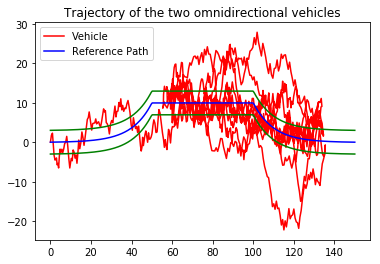

In [27]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now train a simple regression model to output control given the current coordinate.

In [31]:
agent = NeuralNetwork(input_size = 31 * 4)

agent.data_process(path = 'expert_traj.p')
agent.train(num_epoch = 100)


[1,     2] loss: 16.064
[1,    17] loss: 4.015
[1,    32] loss: 3.281
[1,    47] loss: 4.166
[1,    62] loss: 2.418
[1,    77] loss: 1.431
[1,    92] loss: 9.243
[1,   107] loss: 1.088
[1,   122] loss: 1.096
[2,     2] loss: 0.195
[2,    17] loss: 1.400
[2,    32] loss: 16.483
[2,    47] loss: 2.564
[2,    62] loss: 1.180
[2,    77] loss: 1.136
[2,    92] loss: 1.137
[2,   107] loss: 8.842
[2,   122] loss: 1.211
[3,     2] loss: 0.172
[3,    17] loss: 1.200
[3,    32] loss: 1.160
[3,    47] loss: 1.291
[3,    62] loss: 2.366
[3,    77] loss: 16.563
[3,    92] loss: 1.003
[3,   107] loss: 9.046
[3,   122] loss: 1.247
[4,     2] loss: 0.196
[4,    17] loss: 1.248
[4,    32] loss: 1.004
[4,    47] loss: 16.669
[4,    62] loss: 2.486
[4,    77] loss: 1.139
[4,    92] loss: 1.124
[4,   107] loss: 1.172
[4,   122] loss: 9.046
[5,     2] loss: 0.168
[5,    17] loss: 1.121
[5,    32] loss: 1.117
[5,    47] loss: 1.101
[5,    62] loss: 1.136
[5,    77] loss: 1.250
[5,    92] loss: 2.370
[5,   1

[39,   107] loss: 1.222
[39,   122] loss: 1.096
[40,     2] loss: 0.146
[40,    17] loss: 1.001
[40,    32] loss: 1.102
[40,    47] loss: 1.270
[40,    62] loss: 1.151
[40,    77] loss: 17.884
[40,    92] loss: 0.963
[40,   107] loss: 1.042
[40,   122] loss: 1.124
[41,     2] loss: 0.117
[41,    17] loss: 0.928
[41,    32] loss: 0.942
[41,    47] loss: 1.125
[41,    62] loss: 0.925
[41,    77] loss: 1.366
[41,    92] loss: 2.478
[41,   107] loss: 9.126
[41,   122] loss: 1.072
[42,     2] loss: 0.151
[42,    17] loss: 24.407
[42,    32] loss: 1.235
[42,    47] loss: 1.097
[42,    62] loss: 1.071
[42,    77] loss: 1.029
[42,    92] loss: 1.041
[42,   107] loss: 1.087
[42,   122] loss: 2.432
[43,     2] loss: 0.148
[43,    17] loss: 2.557
[43,    32] loss: 1.151
[43,    47] loss: 0.973
[43,    62] loss: 1.034
[43,    77] loss: 0.972
[43,    92] loss: 16.416
[43,   107] loss: 1.089
[43,   122] loss: 1.025
[44,     2] loss: 0.123
[44,    17] loss: 1.122
[44,    32] loss: 1.041
[44,    47] l

[78,    62] loss: 1.046
[78,    77] loss: 1.118
[78,    92] loss: 8.953
[78,   107] loss: 1.033
[78,   122] loss: 1.153
[79,     2] loss: 0.133
[79,    17] loss: 16.542
[79,    32] loss: 0.989
[79,    47] loss: 2.270
[79,    62] loss: 1.081
[79,    77] loss: 1.078
[79,    92] loss: 1.094
[79,   107] loss: 8.974
[79,   122] loss: 1.046
[80,     2] loss: 0.129
[80,    17] loss: 1.212
[80,    32] loss: 1.045
[80,    47] loss: 1.064
[80,    62] loss: 10.345
[80,    77] loss: 16.395
[80,    92] loss: 1.103
[80,   107] loss: 0.969
[80,   122] loss: 0.924
[81,     2] loss: 0.108
[81,    17] loss: 1.128
[81,    32] loss: 10.305
[81,    47] loss: 1.045
[81,    62] loss: 0.897
[81,    77] loss: 16.707
[81,    92] loss: 1.003
[81,   107] loss: 1.084
[81,   122] loss: 1.056
[82,     2] loss: 0.227
[82,    17] loss: 0.959
[82,    32] loss: 2.462
[82,    47] loss: 1.062
[82,    62] loss: 0.991
[82,    77] loss: 1.206
[82,    92] loss: 1.096
[82,   107] loss: 1.130
[82,   122] loss: 16.379
[83,     2

In [32]:

agent_traj = []
x0 = [x_path[0]]  # Initial state.
# Random initial action path.

N = 300
n = 30
for i in range(0, int(N - n) + 1):
    x_path_ = x_path[i: i + n]
    x = []
    for j in x_path_:
        for k in j:
            x.append(k)
    for j in x0[0]:
        x.append(j)

    u = agent.run([x])
    agent_traj = agent_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[-4: ], u[0], i)
    
    print(x0)

[[ 0.50021363  0.07074988 10.00899931  0.17815643]]
[[ 0.99300563  0.15948475 10.01969353  0.36358404]]
[[ 1.4615263   0.33775697 10.03194381  0.53857047]]
[[ 1.89240671  0.59520289 10.04536011  0.68139374]]
[[ 2.28279342  0.91179445 10.05964422  0.77948419]]
[[ 2.64081859  1.26560978 10.07459759  0.82750232]]
[[ 2.98196091  1.63676032 10.08995768  0.82305674]]
[[ 3.32527664  2.00695868 10.10558697  0.76918848]]
[[ 3.68858964  2.35868018 10.12130024  0.67713883]]
[[ 4.08330575  2.67600829 10.13694969  0.56178203]]
[[ 4.51258597  2.9462122  10.15262039  0.42521487]]
[[ 4.97536743  3.15577911 10.16820538  0.27947413]]
[[ 5.46442788  3.29613215 10.18386003  0.13291698]]
[[ 5.96952186  3.36366589 10.19969157 -0.01088261]]
[[ 6.47987901  3.35811165 10.21580324 -0.14604952]]
[[ 6.98564063  3.28371569 10.23235834 -0.26858853]]
[[ 7.47932778  3.14783366 10.24947489 -0.37611026]]
[[ 7.95639224  2.95943641 10.26721172 -0.46449001]]
[[ 8.41577223  2.72926248 10.28555032 -0.52968742]]
[[ 8.8599807

The red curve in the plot shows the trajectory of the regression model controller.

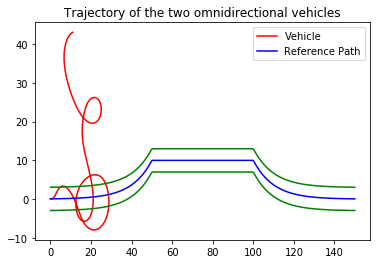

In [33]:

posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append(i[0][-4])
    posy.append(i[0][-3])
    v.append(i[0][-2])
    theta.append(i[0][-1])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [ ]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.

x0 = x_path[0]  # Initial state.
# Random initial action path.
us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))

nn_traj = []
mpc_traj= []
traj = []

for i in range(N - n - 1):
    #print(">>>>>Step {} at {}".format(i, x0))
    u = agent.run([x0])
    #print("NN outputs control")
    agent_traj = agent_traj + [[x0, u[0, :]]]
    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = [20, 20], q2 = [0.01, 0.01], \
                   x_path = x_path_, \
                   x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[0,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        x0 = x0_[0]
        print("Utilize NN output")
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[0,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            xs, us = ilqr.fit(x0, us, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0 = xs[1]
        print("Utilize MPC output")

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

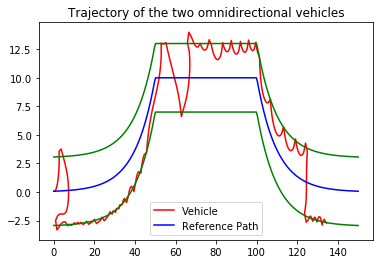

In [31]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

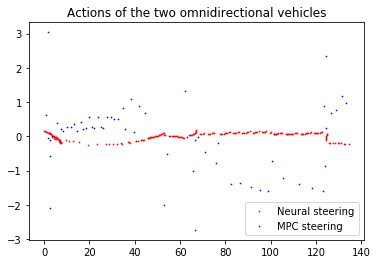

In [32]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
